# **SCRABBLE ASSISTANT**
## DIGITAL IMAGE PROCESSING: COURSE PROJECT

### Team Name: **lena**
### Team Members
- Shaurya Rajat Dewan (2019101017, CSE)
- Chirag Shameek Sahu (2019102006, ECE)
- Harshwardhan Prasad (2019102021, ECE)
- Shivanshu Jain (2019101001, CSE)

### GOAL
With the help of image processing techniques we convert the image of the Scrabble board into a 15 X 15 text matrix.

### PROCEDURE

#### Importing Libraries

The project is based on the language Python 3.7.
The following cells will download and import the necessary libraries required for this project.

In [111]:
''' All neccesary libraries are imported '''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import timeit
from copy import copy, deepcopy

In [112]:
''' Necessary extra steps to install the pytesseract library '''
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


#### Some Necessary Helper Functions 

In [113]:
''' Helper function defined for plotting the necessary outputs '''
def display(imgs, titles, gray, size=(10, 10), rows=1):
    fig = plt.figure(figsize=size)
    
    for i in range(len(imgs)):
        fig.add_subplot(rows, len(imgs) // rows, i + 1)
        if gray[i]:
            plt.imshow(imgs[i], cmap='gray')
        else:
            plt.imshow(imgs[i])

        plt.title(titles[i])

In [115]:
''' Helper function defined for linear contrast stretching of colored images '''
def linContrastStretching(image):
    # Default values
    a=0
    b=255
    
    # Max and min in each level of matrix
    x=np.max(image, axis=0)       
    x=np.max(x, axis=0)
    y=np.min(image, axis=0)
    y=np.min(y, axis=0)
    image=image.astype(float)
    row, column, height = image.shape

    for i in range(row):
        for j in range(column):
            image[i][j][0]=(((b-a)/(x[0]-y[0]))*(image[i][j][0]-y[0])) + a
            image[i][j][1]=(((b-a)/(x[1]-y[1]))*(image[i][j][1]-y[1])) + a
            image[i][j][2]=(((b-a)/(x[2]-y[2]))*(image[i][j][2]-y[2])) + a
            
    image=image.astype(np.uint8)

    return image

In [116]:
''' Helper function to perform Gamma transform of an image '''
def gammaTransform(image, gamma):
    image = image.astype(float)
    image = image / 255
    image = np.power(image, gamma)
    image = image * 255
    image = image.astype(np.uint8)
    
    return image

#### Preprocessing
These are some necessary steps taken before taking a good cropped image.

- Grayscale Conversion

In [117]:
''' Helper function to convert color images to grayscale '''
def rgb2Gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

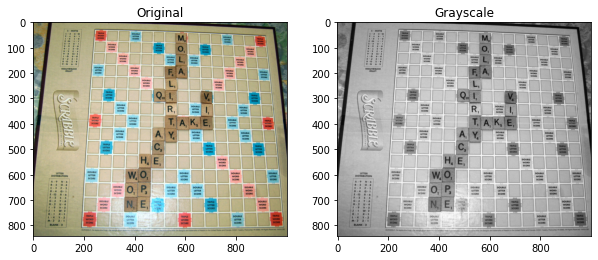

In [118]:
''' Intermediate step to check the working of above function '''
img = mpimg.imread('/content/board1.jpg')
gray = rgb2Gray(img)
display([img, gray], ['Original', 'Grayscale'], [0, 1])

- Adaptive Histogram Equalization

We first compared regular histogram equalization with the adaptive version to check how different are the results. Then we tried various parameters for the adaptive version to find the optimal one. We found that a clip size of 5 and a tile/block size of 11x11 seemed to give the best results.

In [119]:
'''Helper function to implement histogram equalization '''
def adaptiveHistEq(img, clipLimit=5, tileGridSize=(11, 11)):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(img)

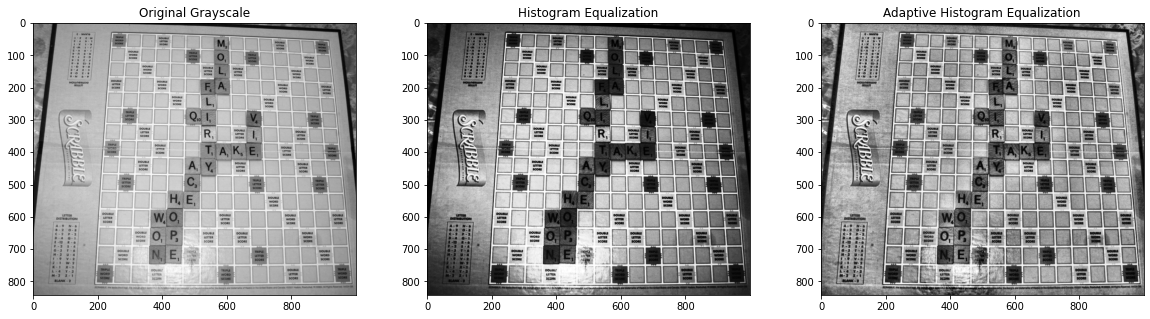

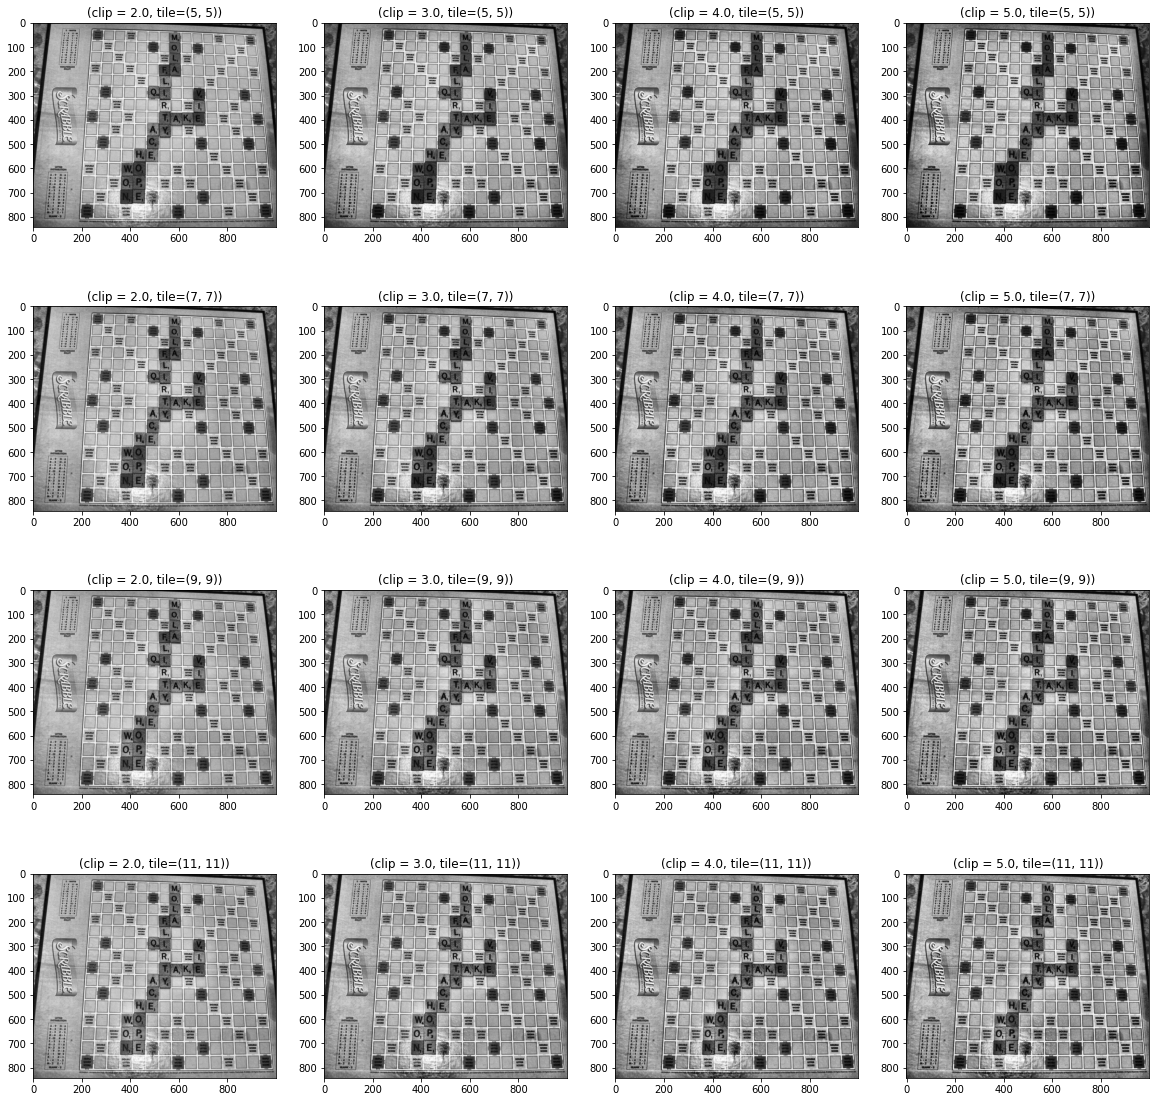

In [25]:
''' Intermediate step to check the working of above function '''
imgArr = []
titleArr = []

for i in range(5, 13, 2):
    for j in np.arange(2, 5.5, 1):
        adaptHist = adaptiveHistEq(gray, j, (i, i))
        imgArr.append(adaptHist)
        titleArr.append('(clip = {}, tile={})'.format(j, (i, i)))

hist = cv2.equalizeHist(gray)
adaptHist = adaptiveHistEq(gray)
display([gray, hist, adaptHist], ['Original Grayscale', 'Histogram Equalization', 'Adaptive Histogram Equalization'], [1] * 3, (20, 5))

display(imgArr, titleArr, [1] * len(imgArr), (20, 20), rows = len(imgArr) // 4)

### Tile Size Detection

This is done in order to normalize the image size in the next step. We obtain the empty boxes/tiles using the MSERs that satisfy certain conditions and use the median of these tiles widths' to estimate the tile size.

In [120]:
'''Helper function to find tile size '''
def getMsers(img, tol=0.001):
    maxArea = img.shape[0] * img.shape[1] / 225
    mser = cv2.MSER_create()
    regions, boundingBoxes = mser.detectRegions(img)
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    smallHulls = []
    widths = []
    for contour in hulls:
        width = np.max(contour[:, 0, 1]) - np.min(contour[:, 0, 1])
        height = np.max(contour[:, 0, 0]) - np.min(contour[:, 0, 0])
        area = width * height
        
        if area >= 100 and area <= maxArea and abs(width - height) <= tol * max(width, height):
            smallHulls.append(contour)
            widths.append(width)

        cv2.drawContours(mask, [contour], -1, (255, 255), -1)

    tileSize = np.median(np.array(widths))
    outline = deepcopy(img)
    cv2.polylines(outline, smallHulls, 1, (0, 255, 0))
    return tileSize, mask, outline, smallHulls

Current Tile Size =  39.0


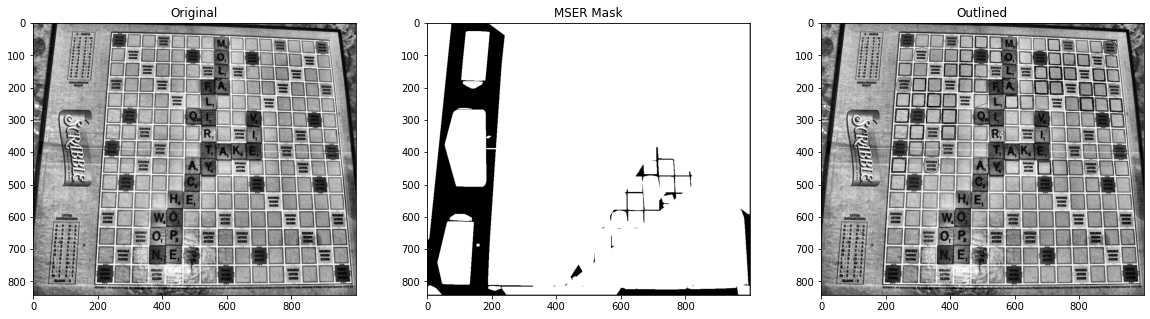

In [41]:
''' Intermediate step to check the working of above function '''
tileSize, mask, outline, smallHulls = getMsers(adaptHist)
print('Current Tile Size = ', tileSize)
display([adaptHist, mask, outline], ['Original', 'MSER Mask', 'Outlined'], [1] * 3, (20, 5))

### Resizing

This is done to normalize the image size such that the tiles width is approximately 30 pixels.

In [121]:
''' Helper function to resize the given image '''
def resizeImg(img, percent):
    width = int(img.shape[1] * percent[0])
    height = int(img.shape[0] * percent[1])
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

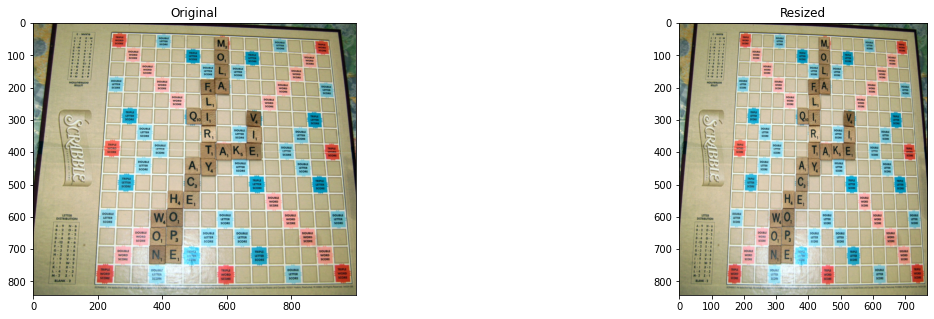

In [42]:
''' Intermediate step to check the working of above function '''
resized = resizeImg(img, [30 / tileSize, 1])
display([img, resized], ['Original', 'Resized'], [1, 1], (20, 5))

#### Grid Detection

We determine the outline of the 15X15 grid of the Scrabble board.

In [122]:
''' Helper function to determine the outline of the Scrabble board '''
def border(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)
    edges = cv2.Canny(blur, 50, 100, apertureSize=3)
    kernel = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(edges, kernel, iterations=2)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    contour_img = img.copy()
    contour_img = cv2.drawContours(contour_img, [cnt], 0, (0, 255, 0), 3)
    epsilon = 0.01 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    x_center = np.mean(approx[:, :, 0])
    y_center = np.mean(approx[:, :, 1])

    pts = np.zeros((4, 2))
    for x in approx:
        for X, Y in x:
            if X < x_center and Y < y_center:
                pts[0, 0] = X
                pts[0, 1] = Y
            if X < x_center and Y > y_center:
                pts[1, 0] = X
                pts[1, 1] = Y
            if X > x_center and Y > y_center:
                pts[2, 0] = X
                pts[2, 1] = Y
            if X > x_center and Y < y_center:
                pts[3, 0] = X
                pts[3, 1] = Y
                
    size = max(approx.flatten()) - min(approx.flatten()) 
    return contour_img, pts, size

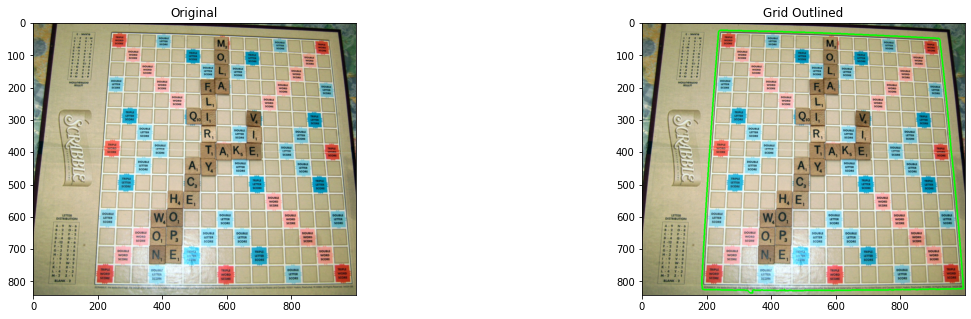

In [29]:
''' Intermediate step to check the working of above function '''
contourImg, pts, size = border(img)
display([img, contourImg], ['Original', 'Grid Outlined'], [0, 0], (20, 5))

#### Perspective Skew Correction

The original image is cropped in such a way that the image is of the 15X15 Scrabble board and the background is removed.

In [123]:
''' Helper function to perform skew correction of the outlined Scrabble board '''
def transform(img, pts, size): 
    pts = np.float32(pts)
    pts_sqr = np.float32([[0, 0], [0, size], [size, size], [size, 0]])
    M = cv2.getPerspectiveTransform(pts, pts_sqr)
    warped_img = cv2.warpPerspective(img, M, (size, size))
    return warped_img

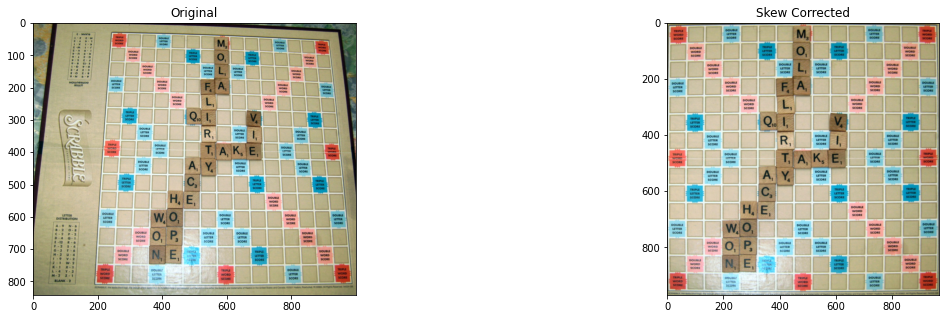

In [30]:
''' Intermediate step to check the working of above function '''
warpedImg = transform(img, pts, size)
display([img, warpedImg], ['Original', 'Skew Corrected'], [0, 0], (20, 5))

#### Grid Fitting
Once the image has been transformed, the board's grid is now roughly aligned with the horizontal and vertical axes.

In [124]:
''' Helper function to perform grid fitting of the skew corrected Scrabble board '''
def gridFitting(img):
    gray = rgb2Gray(img)
    roughtFit = deepcopy(img)
    divs = 15
    
    for i in range(divs + 1):
        roughFit = cv2.line(roughtFit, (0, i * img.shape[1] // divs), (img.shape[0], i * img.shape[1] // divs), (0, 0, 255), 2)
        
    for i in range(divs + 1):
        roughFit = cv2.line(roughtFit, (i * img.shape[0] // divs, 0), (i * img.shape[0] // divs, img.shape[1]), (0, 0, 255), 2)

    mserFit = np.zeros(img.shape)
    bright = gammaTransform(gray, 0.5)
    _, _, _, msersEmpty = getMsers(bright)
    dark = gammaTransform(gray, 1.5)
    _, _, _, msersFill = getMsers(dark, 0.05)

    msers = msersEmpty + msersFill
    cv2.polylines(roughFit, msers, 1, (0, 255, 0))
    kernel = np.zeros((7, 7), np.uint8)
    roughFit = cv2.erode(roughFit, kernel, iterations=1)
    
    mids = []
    for i in range(len(msers)):
        mser = msers[i]
        midR = (np.max(mser[:, 0, 0]) + np.min(mser[:, 0, 0])) // 2
        midC = (np.max(mser[:, 0, 1]) + np.min(mser[:, 0, 1])) // 2
        mids.append([midR, midC])
    
    mids = np.array(mids)
    gridAllot = [-1] * len(msers)
    for i in range(divs):
        minR = i * img.shape[0] // divs
        maxR = (i + 1) * img.shape[0] // divs
        
        for j in range(divs):
            minC = j * img.shape[1] // divs
            maxC = (j + 1) * img.shape[1] // divs
            
            for k in range(len(mids)):
                if mids[k][0] in range(minR, maxR) and mids[k][1] in range(minC, maxC):
                    gridAllot[k] = 15 * i + j
            
    gridAllot = np.array(gridAllot)
    finalFit = deepcopy(img)
    for i in range(divs - 1):
        col = (i + 1) * img.shape[1] // divs
        multiples = np.arange(i, divs ** 2, divs)
        st = set(multiples)
        leftMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        leftMids = mids[leftMidInds, 1]
        
        multiples = np.arange(i + 1, divs ** 2, divs)
        st = set(multiples)
        rightMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        rightMids = mids[rightMidInds, 1]
        
        if len(leftMids) and len(rightMids):
            col = int((np.mean(leftMids) + np.mean(rightMids)) // 2)
        
        finalFit = cv2.line(finalFit, (col, 0), (col, img.shape[0]), (0, 0, 255), 2)
       
    for i in range(divs - 1):
        row = (i + 1) * img.shape[0] // divs
        multiples = np.arange(divs * i, divs * i + divs, 1)
        st = set(multiples)
        leftMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        leftMids = mids[leftMidInds, 0]
        
        multiples = np.arange(divs * (i + 1), divs * (i + 1) + divs, 1)
        st = set(multiples)
        rightMidInds = [i for i, e in enumerate(gridAllot) if e in st]
        rightMids = mids[rightMidInds, 0]
        
        if len(leftMids) and len(rightMids):
            row = int((np.mean(leftMids) + np.mean(rightMids)) // 2)
            
        finalFit = cv2.line(finalFit, (0, row), (img.shape[1], row), (0, 0, 255), 2)
            
    return roughFit, finalFit

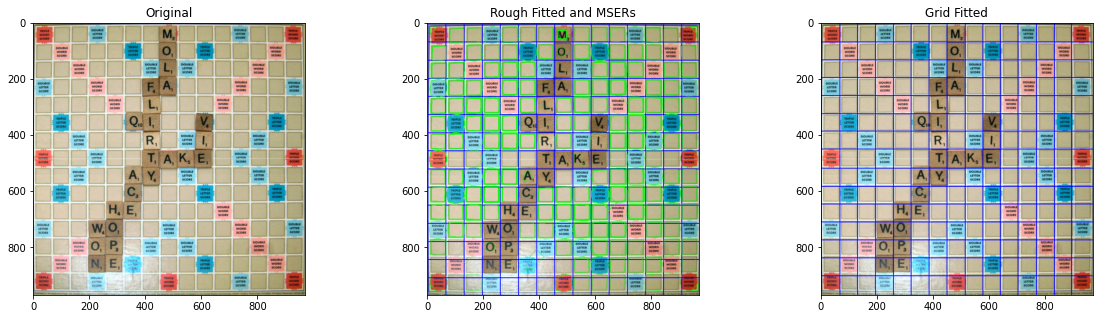

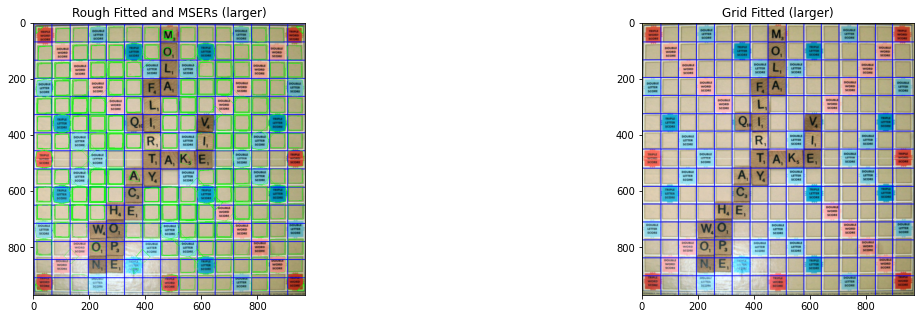

In [73]:
''' Intermediate step to check the working of above function '''
roughImg, fittedImg = gridFitting(warpedImg)
display([warpedImg, roughImg, fittedImg], ['Original', 'Rough Fitted and MSERs', 'Grid Fitted'], [0] * 3, (20, 5))
display([roughImg, fittedImg], ['Rough Fitted and MSERs (larger)', 'Grid Fitted (larger)'], [0] * 2, (20, 5))

#### Character Detection

In [125]:
''' Necessary functions to determine the 8 way connected component labelling of a binary image'''
def find(parent,i):
  if(parent[i]==-1):
      return parent, i

  parent,parent[i]= find(parent, parent[i])
  return parent, parent[i]

def union(parent, u, v):
  parent, x=find(parent, u)
  parent, y=find(parent, v)

  if(x==y):
      return parent
  if(x<y):
      parent[y]=x
  else:
      parent[x]=y
  
  return parent

def component(im):
  im=im&1
  color=np.zeros([im.shape[0], im.shape[1]], dtype=int)
  index=1

  for i in range(len(im)):
      for j in range(len(im[0])):
          if(im[i][j]==0):
              continue          
          
          ans=1000000000            
          # Finding the minimum parent among the neighbours if assigned
          if(i-1>=0 and color[i-1][j]>0  ):
              ans=min(ans,color[i-1][j])
          if(j-1>=0 and color[i][j-1]>0  ):
              ans=min(ans,color[i][j-1]) 
          if(j+1<len(im[0]) and color[i][j+1]>0  ):
              ans=min(ans,color[i][j+1])
          if(i+1<len(im) and color[i+1][j]>0  ):
              ans=min(ans,color[i+1][j])
          if(i-1>=0 and j-1>=0 and color[i-1][j-1]>0):
              ans=min(ans,color[i-1][j-1])
          if(i-1>=0 and j+1<len(im[0]) and color[i-1][j+1]>0):
              ans=min(ans,color[i-1][j+1])
          if( i+1<len(im) and j-1>=0 and color[i+1][j-1]>0):
              ans=min(ans,color[i+1][j-1])
          if( i+1<len(im) and j+1<len(im[0]) and color[i+1][j+1]>0):
              ans=min(ans,color[i+1][j+1])
                          
          if(ans!=1000000000):
              color[i][j]=ans 
          else:
              color[i][j]=index
              index+=1
  
  parent=np.empty(index+1,dtype=int)
  parent.fill(-1)
  
  # Find the common parent if a pixel is assigned different parents.
  for i in range(len(im)):
      for j in range(len(im[0])):
          if(im[i][j]==0):
              continue
          if(i-1>=0 and color[i-1][j]>0):
              x1=min(color[i][j],color[i-1][j])
              x2=max(color[i][j],color[i-1][j])
              parent=union(parent,x1,x2)
          if(j-1>=0 and color[i][j-1]>0):
              x1=min(color[i][j],color[i][j-1])
              x2=max(color[i][j],color[i][j-1])
              parent=union(parent,x1,x2) 
          if(j+1<len(im[0]) and color[i][j+1]>0):
              x1=min(color[i][j],color[i][j+1])
              x2=max(color[i][j],color[i][j+1])
              parent=union(parent,x1,x2)
          if(i+1<len(im) and color[i+1][j]>0):
              x1=min(color[i][j],color[i+1][j])
              x2=max(color[i][j],color[i+1][j])
              parent=union(parent,x1,x2)
          if(i-1>=0 and j-1>=0 and color[i-1][j-1]>0):
              x1=min(color[i][j],color[i-1][j-1])
              x2=max(color[i][j],color[i-1][j-1])
              parent=union(parent,x1,x2)
          if(i-1>=0 and j+1<len(im[0]) and color[i-1][j+1]>0):
              x1=min(color[i][j],color[i-1][j+1])
              x2=max(color[i][j],color[i-1][j+1])
              parent=union(parent,x1,x2)
          if(i+1<len(im) and j-1>=0 and color[i+1][j-1]>0):
              x1=min(color[i][j],color[i+1][j-1])
              x2=max(color[i][j],color[i+1][j-1])
              parent=union(parent,x1,x2)
          if(i+1<len(im) and j+1<len(im[0]) and color[i+1][j+1]>0):
              x1=min(color[i][j],color[i+1][j+1])
              x2=max(color[i][j],color[i+1][j+1])
              parent=union(parent,x1,x2)
  
  for i in range(len(color)):
      for j in range(len(color[0])):
          if(color[i][j]>0):
              parent,color[i][j]=find(parent,color[i][j])
    
  return color

#### Character Recognition

In [126]:
''' Helper function for edge case to detect character I in the image '''
def checkI(img):
    chk_x=img.shape[0]
    chk_y=img.shape[1]
    mn_col=chk_y
    mx_col=0
    mn_row=chk_x
    mx_row=0
    
    for i in range(chk_x):
        for j in range(chk_y):
            if(img[i][j]==255):
                mn_col=min(mn_col,j)
                mx_col=max(mx_col,j)
                mn_row=min(mn_row,i)
                mx_row=max(mx_row,i)
    
    # Finding the foreground pixels
    count1=0
    for i in range(mn_row,mx_row+1):
        for j in range(mn_col,mx_col+1):
            if(img[i][j]==255):
                count1+=1
    col1=mx_col-mn_col
    row1=mx_row-mn_row
    cells = (row1+1)*(col1+1)
    
    # Checking if foreground pixels expand more vertically or horizontally
    if(3*col1>= row1):
        return False
    else:
        if(6*cells <= 10*count1):
            return True
        else:
            return False

In [127]:
''' Performing Character Detection and Recognition '''
def charDetectRecog(img ,x):  
  # Empty Matrix
  matrix=np.empty([15,15],dtype=str)
  matrix.fill("_")

  # Determine the centre of a cell
  side_x=img.shape[1]/30
  side_x=int(side_x)
  side_y=img.shape[0]/30
  side_y=int(side_y)
  pt=[side_y,side_x]
  counter=0
 
  for i in range(15):
      for j in range(15):         
          # Crop the cell
          temp = img[pt[0]-x//2:pt[0]+x//2,pt[1]-x//2:pt[1]+x//2]
          
          # Preprocessing the image with helper functions
          temp = cv2.GaussianBlur(temp,(3,3),cv2.BORDER_DEFAULT)
          temp = linContrastStretching(temp)
          temp = rgb2Gray(temp)
          temp = cv2.equalizeHist(temp)
          
          # Thresholding for character as foreground
          ret, thresh = cv2.threshold(temp,25,255,cv2.THRESH_BINARY)
          thresh = 255-thresh

          # Perform connected component labeling
          thresh = thresh.astype(int)
          thresh = thresh/255
          thresh = thresh.astype(np.uint8)
          color = component(thresh)
          
          # Find all connected components and determine the maximum
          store = []
          for index1 in color:
              for index2 in index1:
                  if index2>0 and index2 not in store:
                      store.append(index2)
          m1=0
          m2=0
          for index in store:
              no=np.count_nonzero(color==index)
              if no>m1:
                  m1=no
                  m2=index
                  
          temp=np.zeros([color.shape[0],color.shape[1]],dtype=np.uint8)
          for index1 in range(len(temp)):
              for index2 in range(len(temp[0])):
                  if color[index1][index2]==m2:
                      temp[index1][index2]=255
        
          # Character Recognition with pytesseract OCR 
          data = pytesseract.image_to_string(255-temp, config='-c tessedit_char_whitelist=|0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')
          
          # Processing for certain characters 
          if data[0]=='0' or (data[0]>="A" and data[0]<="Z"):              
              if data[0]=='0':
                  matrix[i][j]="O"
              elif data[0]=="J" or data[0]=="T" or data[0]=="C" or data[0]=="Z" or data[0]=="D":     
                  kernel = np.ones((2, 2), np.uint8)
                  thresh = cv2.erode(temp, kernel)
                  new_data=pytesseract.image_to_string(255-thresh,config='-c tessedit_char_whitelist=0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')
                  if(new_data[0]==data[0]):
                      matrix[i][j]=data[0]                  
              else:                  
                  if data[0]=="L":
                      kernel = np.ones((3, 3), np.uint8)
                      thresh = cv2.erode(temp, kernel)
                      new_data=pytesseract.image_to_string(255-thresh,config='-c tessedit_char_whitelist=0oABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 6')
                      
                      if new_data[0]=="L" and len(new_data)==3 and ord(new_data[1])==10 and ord(new_data[2])==12:
                          matrix[i][j]="L"
                  elif data[0]=="I":
                      continue
                  else:
                      matrix[i][j]=data[0]              
          
          # Detect I
          elif checkI(temp)==True:
              matrix[i][j]="I"
              
              edger_fg=0
              edgec_fg=0
              chk_x=temp.shape[0]
              chk_y=temp.shape[1]
              
              for i1 in range(chk_y):
                  if(temp[0][i1]==255):
                      edger_fg+=1
                  if(temp[chk_x-1][i1]==255):
                      edger_fg+=1
              for i1 in range(chk_x):
                  if(temp[i1][0]==255):
                      edgec_fg+=1
                  if(temp[i1][chk_y-1]==255):
                      edgec_fg+=1
              if(edger_fg!=0 or edgec_fg!=0):
                  matrix[i][j]="_"
          
          edger_fg=0
          edgec_fg=0
          chk_x=temp.shape[0]
          chk_y=temp.shape[1]
          for i1 in range(chk_y):
              if(temp[0][i1]==255):
                  edger_fg+=1
              if(temp[chk_x-1][i1]==255):
                  edger_fg+=1
          for i1 in range(chk_x):
              if(temp[i1][0]==255):
                  edgec_fg+=1
              if(temp[i1][chk_y-1]==255):
                  edgec_fg+=1
          if(edger_fg!=0 and edgec_fg!=0):
              matrix[i][j]="_"
          
          pt[1]+=2*side_x
          counter+=1
      pt[0]+=2*side_y
      pt[1]=side_x
      
  # Characters with no neighbours are eliminated
  for i in range(15):
      for j in range(15):
          if(matrix[i][j]!="_"):
              count1=0
              if(i>0 and matrix[i-1][j]!="_"):
                  count1+=1
              if(i<14 and matrix[i+1][j]!="_"):
                  count1+=1
              if(j>0 and matrix[i][j-1]!="_"):
                  count1+=1
              if(j<14 and matrix[i][j+1]!="_"):
                  count1+=1

              if(count1==0):
                  matrix[i][j]="_"
  
  # print(matrix)
  return matrix

In [128]:
def tileSize(image):
  image = np.float64(image)
  area = image.shape[0]*image.shape[1]
  area = (95*area)/100
  area = area/225
  tileSz = np.sqrt(area)
  tileSz = int(tileSz)
  return tileSz

#### Board Representation

- Storing In 'output.txt' File

In [129]:
''' Helper function to store the Scrabble Board data in 'output.txt' file '''
def makeFile(matrix):
  with open('output.txt', 'w') as writefile:
    for i in range(15):
      for j in range(15):
        writefile.write(matrix[i][j])
        writefile.write(' ')
      writefile.write('\n')

- Print Scrabble Board Matrix

In [130]:
''' Helper function to pretty print the matrix '''
def prettyPrint(matrix):
  print("OUTPUT\n")
  for i in range(15):
    for j in range(15):
      print(matrix[i][j], end = " ")
    print()

### **MAIN CELL FUNCTION** 
This cell will take the Scrabble board input and return the text output of the board. The output will be stored in the 'output.txt' file.

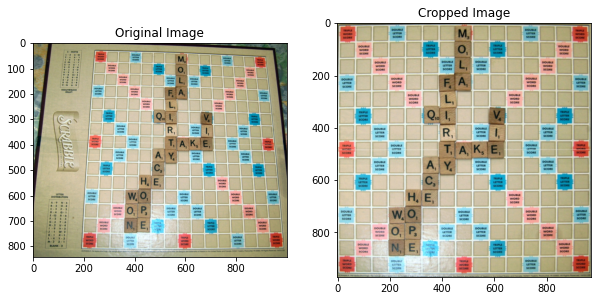

OUTPUT

_ _ _ _ _ _ _ M _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ O _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ L _ _ _ _ _ _ _ 
_ _ _ _ _ _ F A _ _ _ _ _ _ _ 
_ _ _ _ _ _ L _ _ _ _ _ _ _ _ 
_ _ _ _ _ Q I _ _ V _ _ _ _ _ 
_ _ _ _ _ _ R _ _ I _ _ _ _ _ 
_ _ _ _ _ _ T A K E _ _ _ _ _ 
_ _ _ _ _ A Y _ _ _ _ _ _ _ _ 
_ _ _ _ _ C _ _ _ _ _ _ _ _ _ 
_ _ _ _ H E _ _ _ _ _ _ _ _ _ 
_ _ _ W O _ _ _ _ _ _ _ _ _ _ 
_ _ _ O P _ _ _ _ _ _ _ _ _ _ 
_ _ _ N E _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [143]:
''' Main function of the Project '''

location = '/content/board1.jpg'
# Read input
scrabbleBoard = cv2.imread(location)

# Convert to grayscale
scrabbleBoardBW = rgb2Gray(scrabbleBoard)

# Adaptive Histogram Equalization
scrabbleBoardHistEq = adaptiveHistEq(scrabbleBoardBW)

# Find edges of the Scrabble Board and crop the image
contourImg, edgePoints, size = border(scrabbleBoard)
scrabbleBoardWarped = transform(scrabbleBoard, edgePoints, size)

display([cv2.cvtColor(scrabbleBoard, cv2.COLOR_BGR2RGB), cv2.cvtColor(scrabbleBoardWarped, cv2.COLOR_BGR2RGB)], ['Original Image', 'Cropped Image'], [0, 0])
plt.show()

sz = tileSize(scrabbleBoardWarped)

# Character Detection and Recognition
scrabbleMatrix = charDetectRecog(scrabbleBoardWarped, sz)

# Print the Scrabble Board
prettyPrint(scrabbleMatrix)

# Store the output in a file
makeFile(scrabbleMatrix)

## **BONUS: ORACLE**
Determine the best words from the image of the tiles given by the user.

- Import necessary files

In [144]:
import scrabble
from PIL import Image,ImageFilter

- Necessary helper functions

In [145]:
''' Helper function to convert letters to string '''
def listToString(s): 
    str1 = ""    
    for ele in s:
        if(ele=='1'):
          ele='I'
        if(ele=='0'):
          ele='O' 
        str1 += ele  
    return str1 

'''Helper function to crop the image to obtain the alphabets using contours'''
def crop(loc):
    img = cv2.imread(loc)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]
    contours , hierarchy = cv2.findContours(thresh, 1, 2)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w>280 and h>40:
            break
    cropped = img[y:y+h, x:x+w]
    cv2.imwrite('crop_tiles.jpg',255 - cropped)

    return cropped

'''Helper function to obtain the letters with the cropped image as the input'''
def get_letters(loc):
    img = Image.open(loc).convert('L')
    blackwhite = img.point(lambda x: 255 if x < 166 else 0, '1')
    blackwhite.save("tiles_bw.jpg")
    im = Image.open("tiles_bw.jpg")
    smooth_im = im.filter(ImageFilter.SMOOTH_MORE)
    smooth_im = np.asarray(smooth_im)
    kernel = np.ones((3,3),np.uint8)
    smooth_im = cv2.erode(smooth_im,kernel,iterations = 1)
    plt.imshow(smooth_im,cmap = 'gray')
    plt.show()
    text = pytesseract.image_to_string(smooth_im, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 7')
    letters = text.lower()
    letter_list = [x for x in letters]
    # print("Letters Are: " + letters)
    return letter_list

- Cell that will give us the best word from the given tiles and the points earned

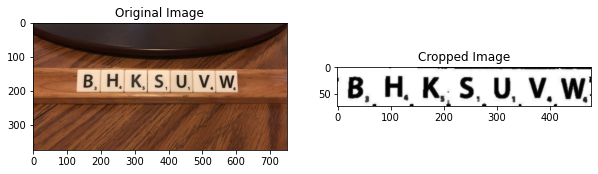

Best words from the given tiles:
11 HUSK
10 BUSK
9 BUSH
9 HUBS
8 HUB
5 BUS
5 SUB
2 US


In [146]:
''' Here we run the cell where the input is the rack of tiles and the output is the list of words '''

location = '/content/3.jpeg'
tiles = cv2.imread(location)
croppedImage = crop(location)
display([cv2.cvtColor(tiles, cv2.COLOR_BGR2RGB), cv2.cvtColor(croppedImage, cv2.COLOR_BGR2RGB)], ['Original Image', 'Cropped Image'], [0, 0])
current_tile_letters = get_letters('crop_tiles.jpg')
string = listToString(current_tile_letters)

print('Best words from the given tiles:')
scrabble.helper(string.upper())